In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import os, re
import shutil
import random
import dill

from sklearn.model_selection import train_test_split
import skimage
from skimage.io import imread, imsave

import tensorflow as tf
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.losses import categorical_crossentropy
from keras.optimizers import adam, sgd
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


## Load Data

* ### init

In [2]:
categories = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
cat_dict = dict(zip(categories, range(len(categories))))
cat_code_dict = dict(zip(range(len(categories)), categories))

In [3]:
# create df
img_path = os.path.join(os.getcwd(), "data/raw_data/resize-mixed")
names = [f.split(".")[0] for f in os.listdir(img_path) if any(c.isdigit() for c in f)]
label_names = [re.sub(r'\d+', '', name) for name in names]
labels = [cat_dict[i] for i in label_names]
paths = [os.path.join(img_path, f+".jpg") for f in names]
dict_df = pd.DataFrame(zip(names, paths, labels, label_names), columns=['name','path', 'label', 'label_names'], dtype=str)
dict_df.head()

,name,path,label,label_names
0,metal296,/Users/loaner/Documents/github/trash-classifie...,2,metal
1,plastic391,/Users/loaner/Documents/github/trash-classifie...,4,plastic
2,cardboard233,/Users/loaner/Documents/github/trash-classifie...,0,cardboard
3,cardboard227,/Users/loaner/Documents/github/trash-classifie...,0,cardboard
4,plastic385,/Users/loaner/Documents/github/trash-classifie...,4,plastic


* ### data augmentation

In [4]:
# image augmentation 
from skimage import transform
def rotate(image_array: np.ndarray):
    '''rotate image with a random degree (between left_degree and right_degree)'''
    degree_limit = 30
    rotate_degree = random.uniform(-degree_limit, degree_limit)
    return transform.rotate(image_array, rotate_degree)*255

def add_noise(image_array: np.ndarray):
    '''add noise to image'''
    return skimage.util.random_noise(image_array)*255

def hor_flip(image_array: np.ndarray):
    '''flipping pixels horizontally'''
    return image_array[:, ::-1]

def ver_flip(image_array: np.ndarray):
    '''flipping pixels vertically'''
    return image_array[::-1, :]

transform_methods = [rotate, add_noise, hor_flip, ver_flip]

In [82]:
def create_more_trash(target_num, base_file_paths, save_path_base, count_for_name):
    num_transformed = 0
    aug_img_df = pd.DataFrame(columns=dict_df.columns)
    
    base_folder = os.path.join('data/raw_data/resized', 'trash')
#     aug_img_path = 'data/raw_data/resize_split/train/trash'
#     aug_path = 'data/raw_data/aug_data'

#     # delete if aug folder already exists (re-aug for every training set)
#     if not os.path.exists(aug_path):
#         os.mkdir(aug_path)
#     else:
#         for f in os.listdir(aug_path):
#             os.remove(os.path.join(aug_path, f))
    
    while num_transformed <= target_num:
        rand_path = random.choice(base_file_paths)
        # base_img = dill.load(open(rand_path, 'rb'))
        base_img = imread(rand_path)

        new_img = transform_methods[random.randint(0,3)](base_img).astype(np.uint8)
        num_transformed += 1
        
        new_img_name = "trash{}".format(str(count_for_name + num_transformed))
#         new_img_path = os.path.join(aug_path, new_img_name)
        new_img_path = os.path.join(save_path_base, new_img_name+".jpg")
        
        aug_img_df = aug_img_df.append({"name":new_img_name, 
                                        "path":new_img_path, 
                                        "label_names": "trash",
                                        "label": cat_dict['trash']},ignore_index=True)
        imsave(new_img_path, new_img)
        # dill.dump(new_img, open(new_img_path, 'wb'))
        # imsave(os.path.join(save_path_base, new_img_name+".jpg"),new_img)
    return aug_img_df

* ### split

In [85]:
def split_and_aug(data_df, test_size):

    X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(data_df, data_df['label'], \
                                                                    test_size=test_size)
    
    # clean out the resize_split folder
    split_dir = 'data/raw_data/resize_split'
    split_train_dir = os.path.join(split_dir, 'train')
    split_test_dir = os.path.join(split_dir, 'test')
    
    if os.path.exists(split_dir):
        shutil.rmtree(split_dir)
        
    os.mkdir(split_dir)
    os.mkdir(split_train_dir)
    os.mkdir(split_test_dir)
    for cat in cat_dict:
        os.mkdir(os.path.join(split_train_dir, cat))
        os.mkdir(os.path.join(split_test_dir, cat))

    
    # data augmentation prep
    trash_base_df = X_train_df[X_train_df['label_names']=='trash']
    trash_base_paths = trash_base_df['path'].tolist()
    if len(trash_base_df[~trash_base_df['name'].str.contains('trash')])!=0:
        raise "label incorrect"  # sanity check
    else:
        avg_numb = int((len(X_train_df)- len(trash_base_paths))/5)
        trash_aug_numb = avg_numb - len(trash_base_paths)
        aug_trash_df = create_more_trash(trash_aug_numb, trash_base_paths, 
                                         os.path.join(split_train_dir, 'trash'),
                                         len(trash_base_df)+1)
        
        print("original trash number: {}, added {} more".format(len(trash_base_df), len(aug_trash_df)))
        
     # copy image to the resize_split folder
    for index, row in X_train_df.iterrows():
        dest_dir = os.path.join('data/raw_data/resize_split', 'train', row['label_names'])
        shutil.copy(row['path'], dest_dir)
        row['path'] = os.path.join(dest_dir, row['name']+".jpg")
    
    for index, row in X_test_df.iterrows():
        dest_dir = os.path.join('data/raw_data/resize_split', 'test', row['label_names'])
        shutil.copy(row['path'], dest_dir)
        row['path'] = os.path.join(dest_dir, row['name']+".jpg")
    
    print("train folder: ", {cat:len(os.walk(os.path.join(split_train_dir, cat)).__next__()[2]) 
                             for cat in os.listdir(split_train_dir)})
    print("test folder: ", {cat:len(os.walk(os.path.join(split_test_dir, cat)).__next__()[2]) 
                            for cat in os.listdir(split_test_dir)})
    
    # load the augmented data into training set
    X_train_df = X_train_df.append(aug_trash_df)
    y_train_df = y_train_df.append(aug_trash_df['label'])

    return X_train_df, X_test_df, y_train_df, y_test_df

* ### image generator

In [7]:
def generate_img_tensor(train_dir, test_dir, im_width, im_height, batch_size):
    
    im_gen = ImageDataGenerator(featurewise_center=False,
                                 samplewise_center=False, 
                                 featurewise_std_normalization=False, 
                                 samplewise_std_normalization=False, 
                                 zca_whitening=False, 
                                 rotation_range=15, 
                                 width_shift_range=0.2, 
                                 height_shift_range=0.2, 
                                 horizontal_flip=True, 
                                 vertical_flip=True)


    train_batch = im_gen.flow_from_directory(train_dir, 
                                             target_size=(im_width, im_height), 
                                             batch_size=batch_size,
                                             shuffle=True)
    test_batch = im_gen.flow_from_directory(test_dir,
                                            target_size=(im_width, im_height), 
                                            batch_size=batch_size, 
                                            shuffle=True)
    
    return train_batch, test_batch

In [8]:
im_gen = ImageDataGenerator(featurewise_center=False,
                             samplewise_center=False, 
                             featurewise_std_normalization=False, 
                             samplewise_std_normalization=False, 
                             zca_whitening=False, 
                             rotation_range=15, 
                             width_shift_range=0.2, 
                             height_shift_range=0.2, 
                             horizontal_flip=True, 
                             vertical_flip=True)

def img_generator(file_dir, im_width, im_height, batch_size):
    return im_gen.flow_from_directory(file_dir, target_size=(im_width, im_height), 
                                      batch_size=batch_size, shuffle=True)

In [9]:
def make_pred(model, img_path, img_w, img_h):
    pic = imread(img_path)
    pic = cv2.resize(pic, (img_w, img_h))
    
    # ensure the same orientation
    dim1 = len(pic)
    dim2 = len(pic[0])
    if dim1 > dim2:
        pic = np.rot90(pic)
        
    pic = np.expand_dims(pic, axis=0)
#     y_class = model.predict_classes(pic)
    y_pred = model.predict(pic) 
    y_class_index = y_pred.argmax(axis=-1)[0]
    return cat_code_dict[y_class_index]

## Build Model

In [10]:
def cnn_model(im_w, im_h):
    
    model = Sequential()
    
#     model.add(keras.layers.Reshape(((im_w//10, im_h//10)), input_shape=(im_w, im_h, 3)))
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(im_w, im_h, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(num_classes, activation='softmax'))
              
    model.summary()
              
    return model


In [11]:
def cnn_model2(img_w, img_h):
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), input_shape=(img_w, img_h, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    return model
    

In [12]:
def alex(img_w, img_h):
    model = Sequential()
    
    model.add(Conv2D(96, (11, 11), strides=4, padding="same", input_shape=(img_w, img_h, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))

    model.add(Conv2D(192, (5, 5), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
    

    model.add(Conv2D(288, (3, 3), padding="same", activation='relu'))
    model.add(Conv2D(288, (3, 3), padding="same", activation='relu'))
    model.add(Conv2D(192, (3, 3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.summary()
    return model
        

## Train and Predict

* ### prep

In [13]:
train_path = 'data/raw_data/resize_split/train'
test_path = 'data/raw_data/resize_split/test'

img_w = 384//8
img_h = 512//8
num_classes = len(cat_dict)

In [15]:
X_train_df, X_test_df, y_train_df, y_test_df = split_and_aug(dict_df, 0.3)

In [382]:
# train_tensor, test_tensor = generate_img_tensor(train_path, test_path, img_w, img_h, batch_size)

Found 2274 images belonging to 6 classes.
Found 506 images belonging to 6 classes.


* ### train (no pretrained model)

In [ ]:
model = alex(img_w, img_h)

In [164]:
checkpoint = ModelCheckpoint('model/cnn_checkpt.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

In [169]:
# model.compile(loss='categorical_crossentropy', optimizer=adam(lr=1.0e-4), metrics=['accuracy'])
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [ ]:
batch_size = 100
train_gen = img_generator(train_path, img_w, img_h, batch_size)
test_gen = img_generator(test_path, img_w, img_h, batch_size)

In [170]:
history = model.fit_generator(train_gen,  
                            validation_data=test_gen,
                            steps_per_epoch=len(X_train_df) // batch_size,
                            validation_steps=len(X_test_df) // batch_size,
                            epochs=300, 
                            verbose=1, 
                            callbacks=[checkpoint])

Epoch 1/300
22/22 [==============================] - 9s 426ms/step - loss: 302.8610 - accuracy: 0.1774 - val_loss: 1.8399 - val_accuracy: 0.1120

Epoch 00001: saving model to model/cnn_checkpt.h5
Epoch 2/300
22/22 [==============================] - 9s 388ms/step - loss: 1.7884 - accuracy: 0.1918 - val_loss: 1.7358 - val_accuracy: 0.2520

Epoch 00002: saving model to model/cnn_checkpt.h5
Epoch 3/300
22/22 [==============================] - 9s 423ms/step - loss: 1.8116 - accuracy: 0.1964 - val_loss: 1.9333 - val_accuracy: 0.1845

Epoch 00003: saving model to model/cnn_checkpt.h5
Epoch 4/300
22/22 [==============================] - 8s 373ms/step - loss: 1.8162 - accuracy: 0.1856 - val_loss: 1.7508 - val_accuracy: 0.2080

Epoch 00004: saving model to model/cnn_checkpt.h5
Epoch 5/300
22/22 [==============================] - 9s 415ms/step - loss: 1.7859 - accuracy: 0.1838 - val_loss: 1.7191 - val_accuracy: 0.2039

Epoch 00005: saving model to model/cnn_checkpt.h5
Epoch 6/300
22/22 [=========

22/22 [==============================] - 9s 393ms/step - loss: 1.7049 - accuracy: 0.2455 - val_loss: 1.6008 - val_accuracy: 0.2520

Epoch 00043: saving model to model/cnn_checkpt.h5
Epoch 44/300
22/22 [==============================] - 9s 391ms/step - loss: 1.7321 - accuracy: 0.2557 - val_loss: 1.6581 - val_accuracy: 0.2718

Epoch 00044: saving model to model/cnn_checkpt.h5
Epoch 45/300
22/22 [==============================] - 9s 406ms/step - loss: 1.7691 - accuracy: 0.2564 - val_loss: 1.8134 - val_accuracy: 0.2840

Epoch 00045: saving model to model/cnn_checkpt.h5
Epoch 46/300
22/22 [==============================] - 9s 394ms/step - loss: 1.7115 - accuracy: 0.2639 - val_loss: 1.7558 - val_accuracy: 0.2720

Epoch 00046: saving model to model/cnn_checkpt.h5
Epoch 47/300
22/22 [==============================] - 9s 403ms/step - loss: 1.7077 - accuracy: 0.2675 - val_loss: 1.6513 - val_accuracy: 0.2718

Epoch 00047: saving model to model/cnn_checkpt.h5
Epoch 48/300
22/22 [==================

Epoch 127/300
22/22 [==============================] - 8s 374ms/step - loss: 1.4016 - accuracy: 0.4950 - val_loss: 1.2731 - val_accuracy: 0.5440

Epoch 00127: saving model to model/cnn_checkpt.h5
Epoch 128/300
22/22 [==============================] - 8s 382ms/step - loss: 1.3736 - accuracy: 0.5055 - val_loss: 1.2882 - val_accuracy: 0.5534

Epoch 00128: saving model to model/cnn_checkpt.h5
Epoch 129/300
22/22 [==============================] - 9s 389ms/step - loss: 1.3164 - accuracy: 0.5455 - val_loss: 1.3587 - val_accuracy: 0.5120

Epoch 00129: saving model to model/cnn_checkpt.h5
Epoch 130/300
22/22 [==============================] - 9s 404ms/step - loss: 1.3945 - accuracy: 0.5114 - val_loss: 1.4671 - val_accuracy: 0.4320

Epoch 00130: saving model to model/cnn_checkpt.h5
Epoch 131/300
22/22 [==============================] - 9s 396ms/step - loss: 1.3550 - accuracy: 0.5036 - val_loss: 1.3306 - val_accuracy: 0.4320

Epoch 00131: saving model to model/cnn_checkpt.h5
Epoch 132/300
22/22 

Epoch 169/300
22/22 [==============================] - 8s 367ms/step - loss: 1.2388 - accuracy: 0.5427 - val_loss: 1.4182 - val_accuracy: 0.5000

Epoch 00169: saving model to model/cnn_checkpt.h5
Epoch 170/300
22/22 [==============================] - 9s 418ms/step - loss: 1.1800 - accuracy: 0.5800 - val_loss: 1.5327 - val_accuracy: 0.4223

Epoch 00170: saving model to model/cnn_checkpt.h5
Epoch 171/300
22/22 [==============================] - 8s 369ms/step - loss: 1.3366 - accuracy: 0.5305 - val_loss: 1.2285 - val_accuracy: 0.5160

Epoch 00171: saving model to model/cnn_checkpt.h5
Epoch 172/300
22/22 [==============================] - 9s 406ms/step - loss: 1.1788 - accuracy: 0.5696 - val_loss: 1.4900 - val_accuracy: 0.5340

Epoch 00172: saving model to model/cnn_checkpt.h5
Epoch 173/300
22/22 [==============================] - 8s 380ms/step - loss: 1.2907 - accuracy: 0.5382 - val_loss: 1.5202 - val_accuracy: 0.5240

Epoch 00173: saving model to model/cnn_checkpt.h5
Epoch 174/300
22/22 

Epoch 211/300
22/22 [==============================] - 9s 389ms/step - loss: 1.1714 - accuracy: 0.5632 - val_loss: 1.1485 - val_accuracy: 0.5360

Epoch 00211: saving model to model/cnn_checkpt.h5
Epoch 212/300
22/22 [==============================] - 9s 409ms/step - loss: 1.2199 - accuracy: 0.5541 - val_loss: 0.9981 - val_accuracy: 0.5728

Epoch 00212: saving model to model/cnn_checkpt.h5
Epoch 213/300
22/22 [==============================] - 8s 368ms/step - loss: 1.2265 - accuracy: 0.5600 - val_loss: 1.1407 - val_accuracy: 0.5160

Epoch 00213: saving model to model/cnn_checkpt.h5
Epoch 214/300
22/22 [==============================] - 9s 401ms/step - loss: 1.1814 - accuracy: 0.5773 - val_loss: 1.2637 - val_accuracy: 0.4078

Epoch 00214: saving model to model/cnn_checkpt.h5
Epoch 215/300
22/22 [==============================] - 8s 368ms/step - loss: 1.1852 - accuracy: 0.5582 - val_loss: 1.0798 - val_accuracy: 0.5920

Epoch 00215: saving model to model/cnn_checkpt.h5
Epoch 216/300
22/22 

Epoch 253/300
22/22 [==============================] - 9s 386ms/step - loss: 1.1295 - accuracy: 0.5973 - val_loss: 0.5419 - val_accuracy: 0.5922

Epoch 00253: saving model to model/cnn_checkpt.h5
Epoch 254/300
22/22 [==============================] - 9s 394ms/step - loss: 1.1289 - accuracy: 0.5864 - val_loss: 1.2175 - val_accuracy: 0.5400

Epoch 00254: saving model to model/cnn_checkpt.h5
Epoch 255/300
22/22 [==============================] - 8s 383ms/step - loss: 1.3867 - accuracy: 0.5214 - val_loss: 1.0995 - val_accuracy: 0.5200

Epoch 00255: saving model to model/cnn_checkpt.h5
Epoch 256/300
22/22 [==============================] - 9s 421ms/step - loss: 1.1523 - accuracy: 0.6082 - val_loss: 1.9385 - val_accuracy: 0.4272

Epoch 00256: saving model to model/cnn_checkpt.h5
Epoch 257/300
22/22 [==============================] - 8s 375ms/step - loss: 1.1770 - accuracy: 0.5823 - val_loss: 1.2497 - val_accuracy: 0.5200

Epoch 00257: saving model to model/cnn_checkpt.h5
Epoch 258/300
22/22 

Epoch 295/300
22/22 [==============================] - 9s 398ms/step - loss: 1.0744 - accuracy: 0.6218 - val_loss: 1.3371 - val_accuracy: 0.4563

Epoch 00295: saving model to model/cnn_checkpt.h5
Epoch 296/300
22/22 [==============================] - 9s 387ms/step - loss: 1.1890 - accuracy: 0.6142 - val_loss: 1.0525 - val_accuracy: 0.5680

Epoch 00296: saving model to model/cnn_checkpt.h5
Epoch 297/300
22/22 [==============================] - 8s 353ms/step - loss: 1.1829 - accuracy: 0.5887 - val_loss: 1.0705 - val_accuracy: 0.5146

Epoch 00297: saving model to model/cnn_checkpt.h5
Epoch 298/300
22/22 [==============================] - 9s 399ms/step - loss: 1.1495 - accuracy: 0.6027 - val_loss: 1.2537 - val_accuracy: 0.4880

Epoch 00298: saving model to model/cnn_checkpt.h5
Epoch 299/300
22/22 [==============================] - 9s 390ms/step - loss: 1.1357 - accuracy: 0.5891 - val_loss: 2.3973 - val_accuracy: 0.5640

Epoch 00299: saving model to model/cnn_checkpt.h5
Epoch 300/300
22/22 

In [171]:
# from keras.models import save_model
# save_model(model, 'model/cnn_3.h5')
model.save('model/cnn_3.h5')
# new_model = keras.models.load_model('path_to_my_model.h5')

* ### plotting

In [16]:
# import pydot, graphviz
# tf.keras.utils.plot_model(
#     model,
#     show_shapes=True,
#     show_layer_names=True,
#     rankdir='TB',
#     expand_nested=False,
#     dpi=96
# )

In [14]:
# plot function
def plot_history(history, start=0):
    plt.plot(history.history['accuracy'], )
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'][start:])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    

In [15]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# evaluation
def make_eval(model, test_gen):
    metrics_names = model.metrics_names
    metrics_values = model.evaluate_generator(generator=test_gen, steps=(len(X_test_df) // batch_size))
    print(dict(zip(metrics_names, metrics_values)))

# def performance_report(model, X_test, y_test_df, classes, batch_size=32, binary=False):    
#     y_true = y_test_df.tolist()
#     y_pred = model.predict_classes(X_test, batch_size=batch_size)
    
#     print("Accuracy : "+ str(accuracy_score(y_true,y_pred)))
#     print("Classification Report")
#     print(classification_report(y_true,y_pred,digits=5))    
    
#     cnf_matrix = confusion_matrix(y_true,y_pred)
#     print(cnf_matrix)
#     plot_confusion_matrix(cnf_matrix,classes=classes)

In [271]:
#  prediction
make_pred(model, 'img_pred/metal.jpg', img_w, img_h)

array([2])

In [306]:
make_eval(model)

{'loss': 0.9746749997138977, 'accuracy': 0.5820000171661377}


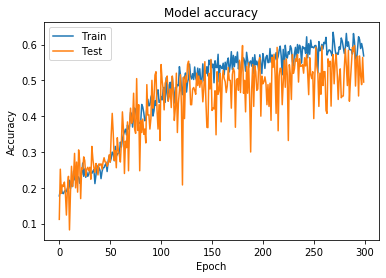

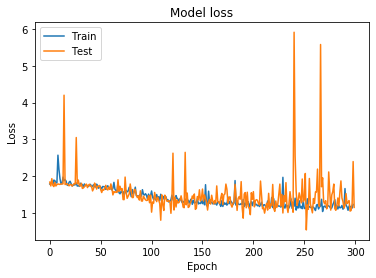

In [239]:
plot_history(history,start=1)

## pretrained model - vgg19

* #### Set up data

In [16]:
from keras.applications import VGG19, ResNet50
from keras.layers import GlobalAveragePooling2D
from keras.models import Model

In [17]:
lr = 0.00012
l2_alpha = 0.001
batch_size = 50

In [20]:
train_gen = img_generator(train_path, img_w, img_h, batch_size)
test_gen = img_generator(test_path, img_w, img_h, batch_size)

Found 1976 images belonging to 6 classes.
Found 759 images belonging to 6 classes.


* #### Set up vgg model and add custom model

In [ ]:
# base models
vgg=VGG19(weights='imagenet', include_top=False, input_shape = (img_w, img_h, 3))
# res50 = ResNet50(include_top=False, weights='imagenet', input_shape = (img_w, img_h, 3))

In [ ]:
for layer in vgg.layers[:-5]:
    layer.trainable = False
    if isinstance(layer, keras.layers.Conv2D) or isinstance(layer, keras.layers.Dense):
        layer.add_loss(keras.regularizers.l2(l2_alpha)(layer.kernel))

In [ ]:
# adding custom Layers 
x = vgg.output
x = Flatten()(x)
x = Dense(2048, activation="relu")(x)
x = Dropout(0.45)(x)
x = Dense(2048, activation="relu")(x)
x = Dropout(0.45)(x)
y = Dense(num_classes, activation="softmax")(x)

In [ ]:
# combined model 

combo_vgg_9 = Model(input = vgg.input, output = y)
combo_vgg_9.compile(loss = "categorical_crossentropy", 
                  optimizer= keras.optimizers.Adam(learning_rate=lr), 
                  metrics=["accuracy"])

In [ ]:
checkpoint = ModelCheckpoint("model/vgg_9.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

In [ ]:
combo_vgg_9.summary()

* #### Find best learning rate

Epoch 1/7
16/16 [==============================] - 44s 3s/step - loss: 6.5646 - accuracy: 0.1865
Epoch 2/7
16/16 [==============================] - 40s 2s/step - loss: 2.8765 - accuracy: 0.2315
Epoch 3/7
16/16 [==============================] - 41s 3s/step - loss: 2.6264 - accuracy: 0.2895
Epoch 4/7
16/16 [==============================] - 48s 3s/step - loss: 2.6689 - accuracy: 0.2550
Epoch 5/7
16/16 [==============================] - 46s 3s/step - loss: 2.7421 - accuracy: 0.2148
Epoch 6/7
16/16 [==============================] - 41s 3s/step - loss: 2.7480 - accuracy: 0.2049
Epoch 7/7
 7/16 [============>.................] - ETA: 22s - loss: 106121183.7988 - accuracy: 0.2020

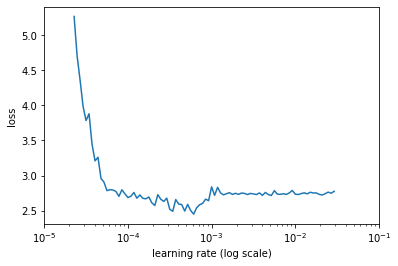

In [85]:
# method 1 - utils
from utils.lr_finder1 import LRFinder1
lr_finder1 = LRFinder1(combo_vgg_8)
# lr_finder1 = LRFinder1(combo_res50_1)
lr_finder1.find_generator(train_gen, 1e-5, 1e-1, epochs=7, steps_per_epoch=len(X_train_df) // batch_size)
lr_finder1.restore_weights()
lr_finder1.plot_loss()

In [86]:
# method 2 - lr_helper
# from utils.lr_finder2 import LRFinder2

# lr_finder2 = LRFinder2(min_lr=1e-5, max_lr=1, mom=0.9, reload_weights=True, batches_lr_update=3)

# combo_vgg_7.fit_generator(train_gen, 
#                           train_gen.n//train_gen.batch_size, 
#                           validation_data=test_gen, 
#                           validation_steps=test_gen.n//test_gen.batch_size,
#                           verbose = 1,
#                           epochs = 10,
#                           callbacks=[lr_finder2])

In [106]:
# update lr rate, regen
import keras.backend as K

K.set_value(combo_vgg_8.optimizer.learning_rate, 0.00015)
print(combo_vgg_8.optimizer.learning_rate)

<tf.Variable 'Adam/learning_rate:0' shape=() dtype=float32, numpy=0.00015>


In [ ]:
# regen
X_train_df, X_test_df, y_train_df, y_test_df = split_and_aug(dict_df, 0.25)
batch_size = 128
train_gen = img_generator(train_path, img_w, img_h, batch_size)
test_gen = img_generator(test_path, img_w, img_h, batch_size)

* #### Grid search?

* #### class weight

In [ ]:
from sklearn.utils import class_weight
from collections import Counter

class_ct = dict_df['name'].groupby(dict_df['label_names']).count().to_dict()
class_ct_convert = {cat_dict[key]:class_ct[key] for key in class_ct}

def calc_class_weights(y):
    counter = Counter(y)
    majority = max(counter.values())
    return  {cls: float(majority/count) for cls, count in counter.items()}

class_weights = calc_class_weights(class_ct_convert)
class_weights

* #### Training model

In [ ]:
# training model
history_vgg_9 = combo_vgg_9.fit_generator(train_gen,  
                            validation_data=test_gen,
                            steps_per_epoch=len(X_train_df) // batch_size,
                            validation_steps=len(X_test_df) // batch_size,
                            epochs=250, 
                            verbose=1,
                            class_weight = class_weights,
                            callbacks=[checkpoint])

In [ ]:
make_eval(combo_vgg_9, test_gen)

In [ ]:
make_pred(combo_vgg_9, 'img_pred/metal.jpg', img_w, img_h)

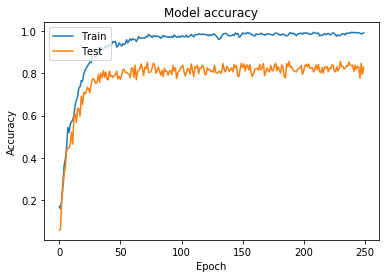

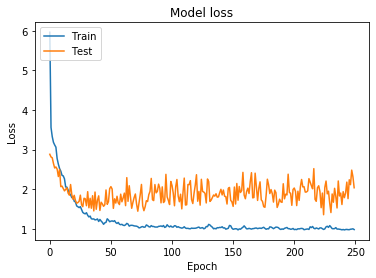

In [33]:
plot_history(history_vgg_8,start=0)

In [ ]:
plot_history(history_vgg_9,start=0)

In [ ]:
from keras.models import load_model

test_model8 = load_model('model/vgg_8.h5')
test_model9 = load_model('model/vgg_9.h5')

In [ ]:
{f:make_pred(test_model8, os.path.join('img_pred', f), img_w, img_h) for f in os.listdir('img_pred') if f.split(".")[0]} 
{f:make_pred(test_model9, os.path.join('img_pred', f), img_w, img_h) for f in os.listdir('img_pred') if f.split(".")[0]} 

In [59]:
combo_vgg_8.save('model/vgg_9_final.h5')

In [60]:
test_model_final = load_model('model/vgg_8_final.h5')
{f:make_pred(test_model_final, os.path.join('img_pred', f), img_w, img_h) for f in os.listdir('img_pred') if f.split(".")[0]} 

{'plastic_bottle.jpg': 'plastic',
 'paper.jpg': 'paper',
 'metal.jpg': 'metal',
 'plastic_crushed.jpg': 'plastic',
 'cardboard_dirtypizza2.jpg': 'cardboard',
 'cardboard_dirtypizza2.jpeg': 'cardboard',
 'cardboard_dirtypizza.jpg': 'cardboard',
 'cardboard_pizzabox.jpg': 'cardboard',
 'trash.jpg': 'trash',
 'cardboard.jpg': 'cardboard',
 'glass.jpg': 'glass',
 'cardboard_dirtypizza_less.jpg': 'cardboard'}

* ### using vgg16, trying other dropout structure

In [35]:
from keras.applications import VGG16

vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(img_w, img_h, 3))

for layer in vgg16.layers:
    layer.trainable = False

# adding custom Layers 
x2 = vgg16.output
x2 = Flatten()(x2)
x2 = Dense(4096, activation="relu")(x2)
x2 = Dropout(0.5)(x2)
x2 = Dense(4096, activation="relu")(x2)
x2 = Dropout(0.5)(x2)
y2= Dense(num_classes, activation="softmax")(x2)

combo_vgg16_2 = Model(input = vgg16.input, output = y2)
combo_vgg16_2.compile(loss = "categorical_crossentropy", 
                  optimizer= keras.optimizers.Adam(learning_rate=lr), 
                  metrics=["accuracy"])

/Users/loaner/.local/share/virtualenvs/trash-classifier-Blx31XfF/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [36]:
combo_vgg16_2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 48, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 16, 128)       0   

In [86]:
# regen
X_train_df, X_test_df, y_train_df, y_test_df = split_and_aug(dict_df, 0.25)
batch_size = 128
train_gen = img_generator(train_path, img_w, img_h, batch_size)
test_gen = img_generator(test_path, img_w, img_h, batch_size)

original trash number: 100, added 260 more
train folder:  {'paper': 445, 'metal': 299, 'cardboard': 302, 'trash': 335, 'glass': 375, 'plastic': 374}
test folder:  {'paper': 149, 'metal': 111, 'cardboard': 101, 'trash': 37, 'glass': 126, 'plastic': 108}
Found 2130 images belonging to 6 classes.
Found 632 images belonging to 6 classes.


Epoch 1/7
16/16 [==============================] - 25s 2s/step - loss: 3.3930 - accuracy: 0.5270
Epoch 2/7
16/16 [==============================] - 29s 2s/step - loss: 3.3482 - accuracy: 0.5534
Epoch 3/7
16/16 [==============================] - 30s 2s/step - loss: 3.0592 - accuracy: 0.5465
Epoch 4/7
16/16 [==============================] - 27s 2s/step - loss: 2.9591 - accuracy: 0.5435
Epoch 5/7
14/16 [=========================>....] - ETA: 3s - loss: 5.0017 - accuracy: 0.5028

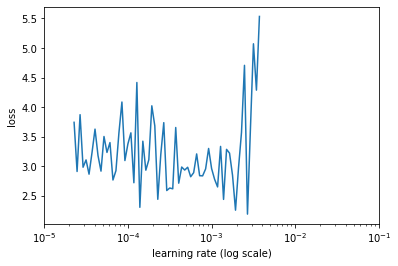

In [93]:
from utils.lr_finder1 import LRFinder1
lr_finder1 = LRFinder1(combo_vgg16_1)
# lr_finder1 = LRFinder1(combo_res50_1)
lr_finder1.find_generator(train_gen, 1e-5, 1e-1, epochs=7, steps_per_epoch=len(X_train_df) // batch_size)
lr_finder1.restore_weights()
lr_finder1.plot_loss()

In [94]:
import keras.backend as K

K.set_value(combo_vgg16_1.optimizer.learning_rate, 0.00012)
print(combo_vgg16_1.optimizer.learning_rate)

<tf.Variable 'Adam/learning_rate:0' shape=() dtype=float32, numpy=0.00012>


In [ ]:
# training model
checkpoint_vgg16 = ModelCheckpoint('model/vgg16_1.h5', monitor='val_accuracy', verbose=1, save_best_only=True,save_weights_only=False, mode='auto')
history_vgg16_1 = combo_vgg16_1.fit_generator(train_gen,  
                            validation_data=test_gen,
                            steps_per_epoch=len(X_train_df) // batch_size,
                            validation_steps=len(X_test_df) // batch_size,
                            epochs=250, 
                            verbose=1,
                            class_weight = class_weights,
                            callbacks=[checkpoint_vgg16])

Epoch 1/250
16/16 [==============================] - 32s 2s/step - loss: 4.8514 - accuracy: 0.5325 - val_loss: 0.8714 - val_accuracy: 0.6934

Epoch 00001: val_accuracy improved from -inf to 0.69336, saving model to model/vgg16_1.h5
Epoch 2/250
16/16 [==============================] - 32s 2s/step - loss: 4.7699 - accuracy: 0.5340 - val_loss: 0.8401 - val_accuracy: 0.6905

Epoch 00002: val_accuracy did not improve from 0.69336
Epoch 3/250
16/16 [==============================] - 31s 2s/step - loss: 4.1616 - accuracy: 0.5589 - val_loss: 0.8587 - val_accuracy: 0.6825

Epoch 00003: val_accuracy did not improve from 0.69336
Epoch 4/250
16/16 [==============================] - 31s 2s/step - loss: 4.2945 - accuracy: 0.5440 - val_loss: 0.8855 - val_accuracy: 0.7202

Epoch 00004: val_accuracy improved from 0.69336 to 0.72024, saving model to model/vgg16_1.h5
Epoch 5/250
16/16 [==============================] - 32s 2s/step - loss: 4.1260 - accuracy: 0.5566 - val_loss: 0.9715 - val_accuracy: 0.680

In [ ]:
make_eval(combo_vgg16_1, test_gen)

In [ ]:
plot_history(history_vgg16_1, start=0)

In [ ]:
test_model_vgg16 = load_model('model/vgg16_1.h5')
{f:make_pred(test_model_vgg16, os.path.join('img_pred', f), img_w, img_h) for f in os.listdir('img_pred') if f.split(".")[0]} 